# load essential and useful packages

In [14]:
import numpy as np
import os
from glob import glob
import tensorflow.compat.v1 as tf
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import h5py, corner
from scipy.interpolate import interp1d

os.chdir('notebooks/ai4astro') # This is my working directory

# load data, inspect and clean

In [3]:
with h5py.File('AllFile3.h5','r') as f:
    for key in f.keys():
        print(key, '\t\t', f[key].shape)

AveDatas 		 (451071, 84, 14)
LFDatas_10 		 (451071, 100, 3)
LFDatas_12 		 (451071, 100, 3)
LFDatas_15 		 (451071, 100, 3)
LFDatas_6 		 (451071, 100, 3)
LFDatas_7 		 (451071, 100, 3)
LFDatas_8 		 (451071, 100, 3)
TauDatas 		 (451071,)
TotalPSDatas 		 (451071, 16, 85)
WalkerCosmologys 		 (451071, 7)
Walkers 		 (451071, 104)
walkerIDs 		 (451071,)


This file contains data for 451,071 models that we have previously performed (for a Bayesian inference work; see [HERA 2022](https://iopscience.iop.org/article/10.3847/1538-4357/ac2ffc)). Each model has shows a number of datasets including the follows.

`AveDatas`: this contains 13 properties of the intergalactic medium at 84 snapshots. The 14 columns correspond to redshift, neutral fraction, 21-cm brightness temperature, photoionizing rate, kinectic temperature, spin temperature, and etc... 


`LFDatas_*`: these are galaxy UV luminosity functions at redshifts 6 to 15. The luminosity function has 100 bins and, in each bin, the 3 values correspond to Muv, number density and halo mass.


`TauDatas`: this saves the optical depth of the cosmic microwave background (CMB) photons.


`TotalPSDatas`: this contains the 21-cm power at 16 wavenumbers across the 84 snapshots mentioned above (but in a reversed order). The first columns (i.e. `f['TotalPSDatas'][:,:,0]`) are identical which save the value of the 16 wavenumbers.


`WalkerCosmologys`: this saves the random seed and 6 cosmological parameters including $\sigma_8$, $h$, $\Omega_{\rm m}$, $\Omega_{\Lambda}$, $\Omega_{\rm b}$ and $n_{\rm s}$. Note that in this particular run, we have kept cosmology and random seed fixed. Therefore, values for all models in this dataset are all the same.


`Walkers`: this saves a list of 20 astrophysical parameters of the model followed by values of the 84 redshifts. e.g. f['AveDatas'][0,:,0]==f['Walkers'][0,20:][::-1] (note the reversed order). Among the 20 astro parameters, only 9 are variables in this case and they are: 

   "$\log_{10} f_{*,10}$" and "$\alpha_*$": normalization and scaling index of the stellar-to-halo-mass ratio; 

   "$\log_{10} f_{\rm esc, 10}$" and "$\alpha_{\rm esc}$": normalization and scaling index of the UV-ionizing-escape fraction to halo mass ratio; 

   "$\log_{10}[M_{\rm turn}/{\rm M}_{\odot}]$": a characteristic halo mass below which galaxy formation becomes increasingly difficult; 

   "$t_*$": star formation time scale in units of the Hubble time; 

   "$\log_{10}\frac{L_{\rm X<2keV}/{\rm SFR}}{{\rm erg\ s^{-1}\ M_{\odot}^{-1}\ yr}}$": X-ray luminosity per star formation rate; 

   "$E_0/{\rm eV}$": minimum energy for X-ray photons to escape from the host galaxy; and finally 

   "$\alpha_{\rm X}$": the X-ray SED scaling index.


`walkerIDs`: this contains internal ID for each model when running the inference.

In [54]:
# the following indices grab our model parameters from `Walkers`
inds = [1,2,3,4,5,6,10,11,14]

# define the meaning for the features, i.e. your model parameters
parameters = np.array([r"$\log_{10} f_{*,10}$",
                       r"$\alpha_*$",
                       r"$\log_{10} f_{\rm esc, 10}$",
                       r"$\alpha_{\rm esc}$",
                       r"$\log_{10}[M_{\rm turn}/{\rm M}_{\odot}]$",
                       r"$t_*$",
                       r"$\log_{10}\frac{L_{\rm X<2keV}/{\rm SFR}}{{\rm erg\ s^{-1}\ M_{\odot}^{-1}\ yr}}$",
                       r"$E_0/{\rm keV}$",
                       r"$\alpha_{\rm X}$"])
                       
# and their limits
limits = np.array([[-3,0], [-0.5,1], [-3,0],[-1,0.5], [8,10], [0.01,1], [38,42], [0.1,1.5], [-1,3]])

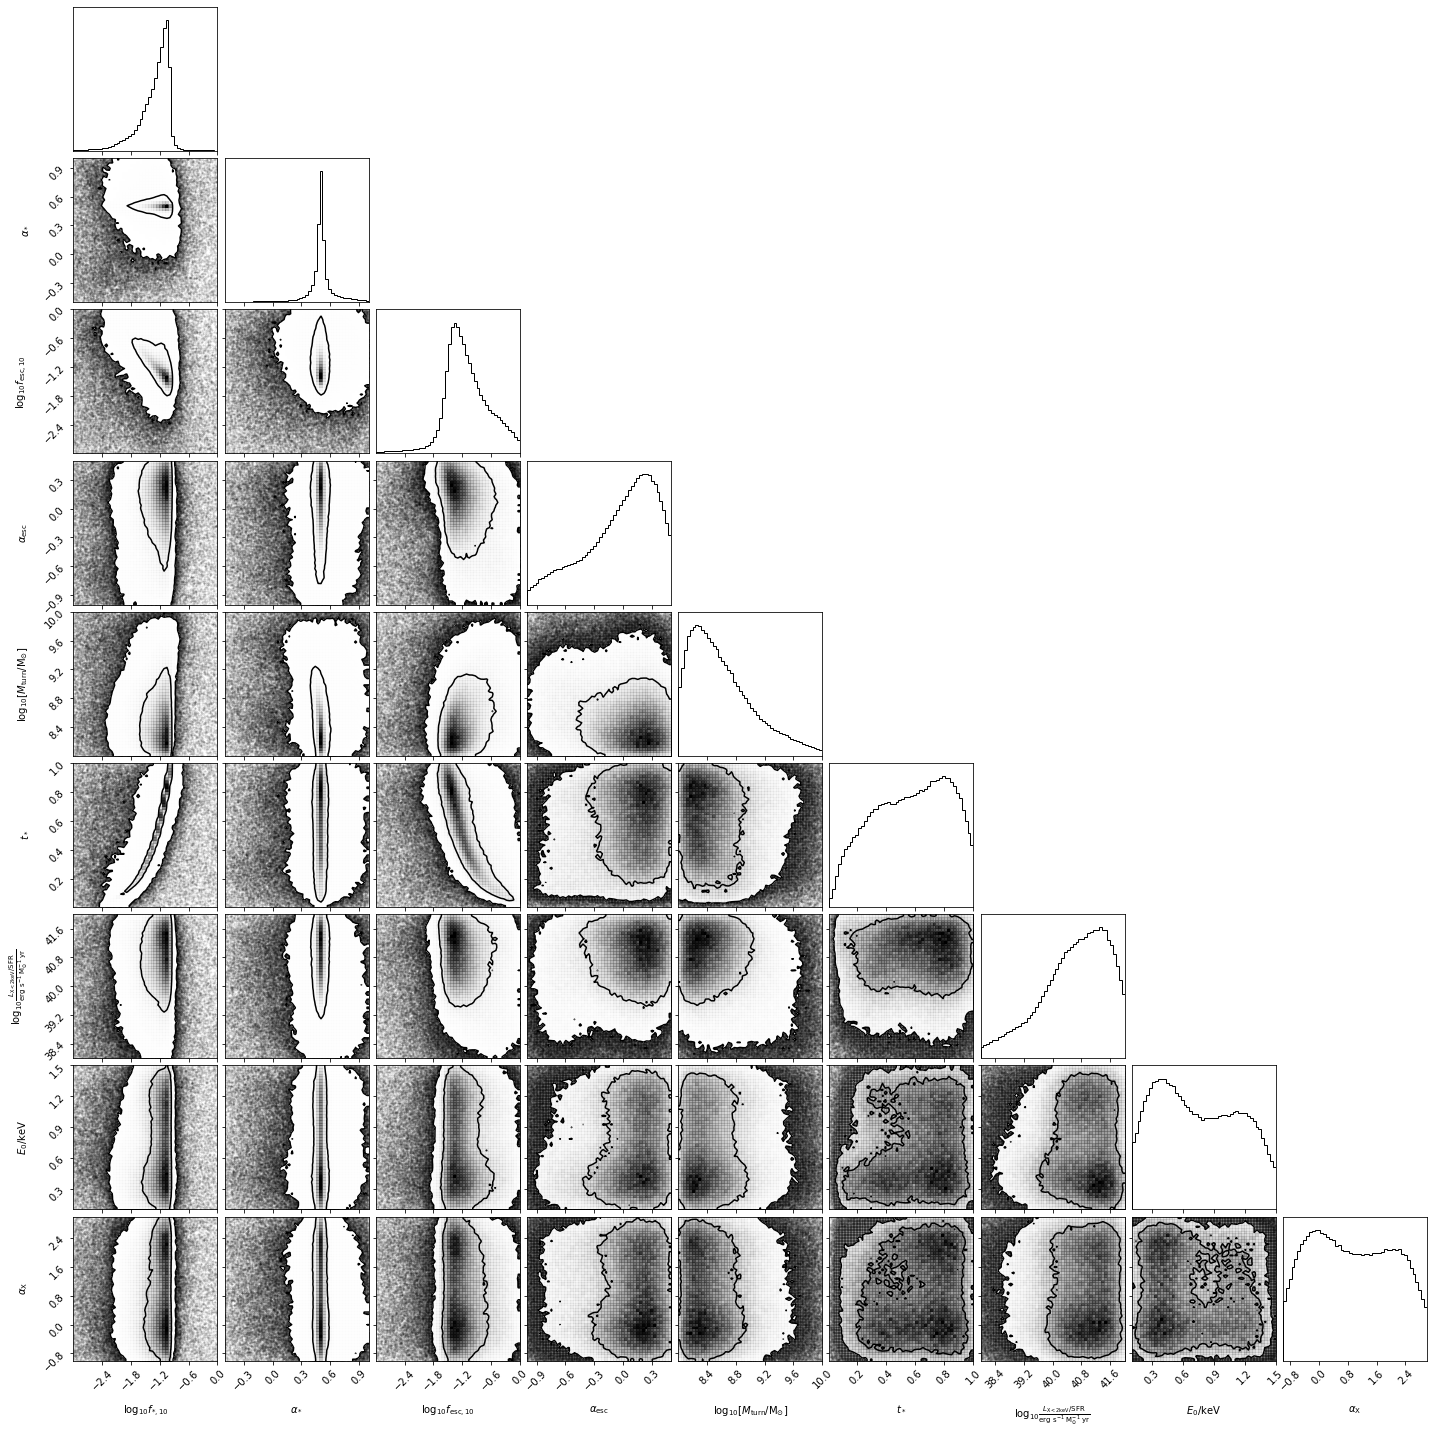

In [56]:
with h5py.File('AllFile3.h5','r') as f:
    
    # features are stored as `Walkers` dataset, with only 9 columns (defined as the `inds` array) varied in the database
    features = f['Walkers'][:,inds]
    
    # change units of E_0 from eV to keV
    features[:,7] /= 1e3 
    
figure = corner.corner(features, bins=50,range=limits, alpha=0.5, labels=parameters, plot_contour=True, levels=[ 0.68, 0.95])

## load the posterior

Note again, the entire ~0.5M database was built through a Bayesian inference run. Therefore we do have a posterior to compare with after having an emulator

In [70]:
posterior = np.loadtxt('MultiNest/21CMMC-post_equal_weights.dat') 
print (posterior.shape)
print (posterior[0])

(58137, 10)
[  0.58046517   0.85436458   0.94719177   0.78806241   0.36609679
   0.59907438   0.42937125   0.52440548   0.32835382 -37.24787947]


MultiNest output contains normalized parameters by mapping points in the range of `limits` to [0,1]. The last column gives lnL

### let's rescaled them back and visualize the distribution


[-1.199911   0.511392  -1.307117  -0.147179   8.09148    0.605263
 40.635032   1.0882626  1.612343 ] 
 [-1.19991145  0.51139201 -1.30711652 -0.14717907  8.09147971  0.60526316
 40.63503223  1.0882626   1.6123434 ]


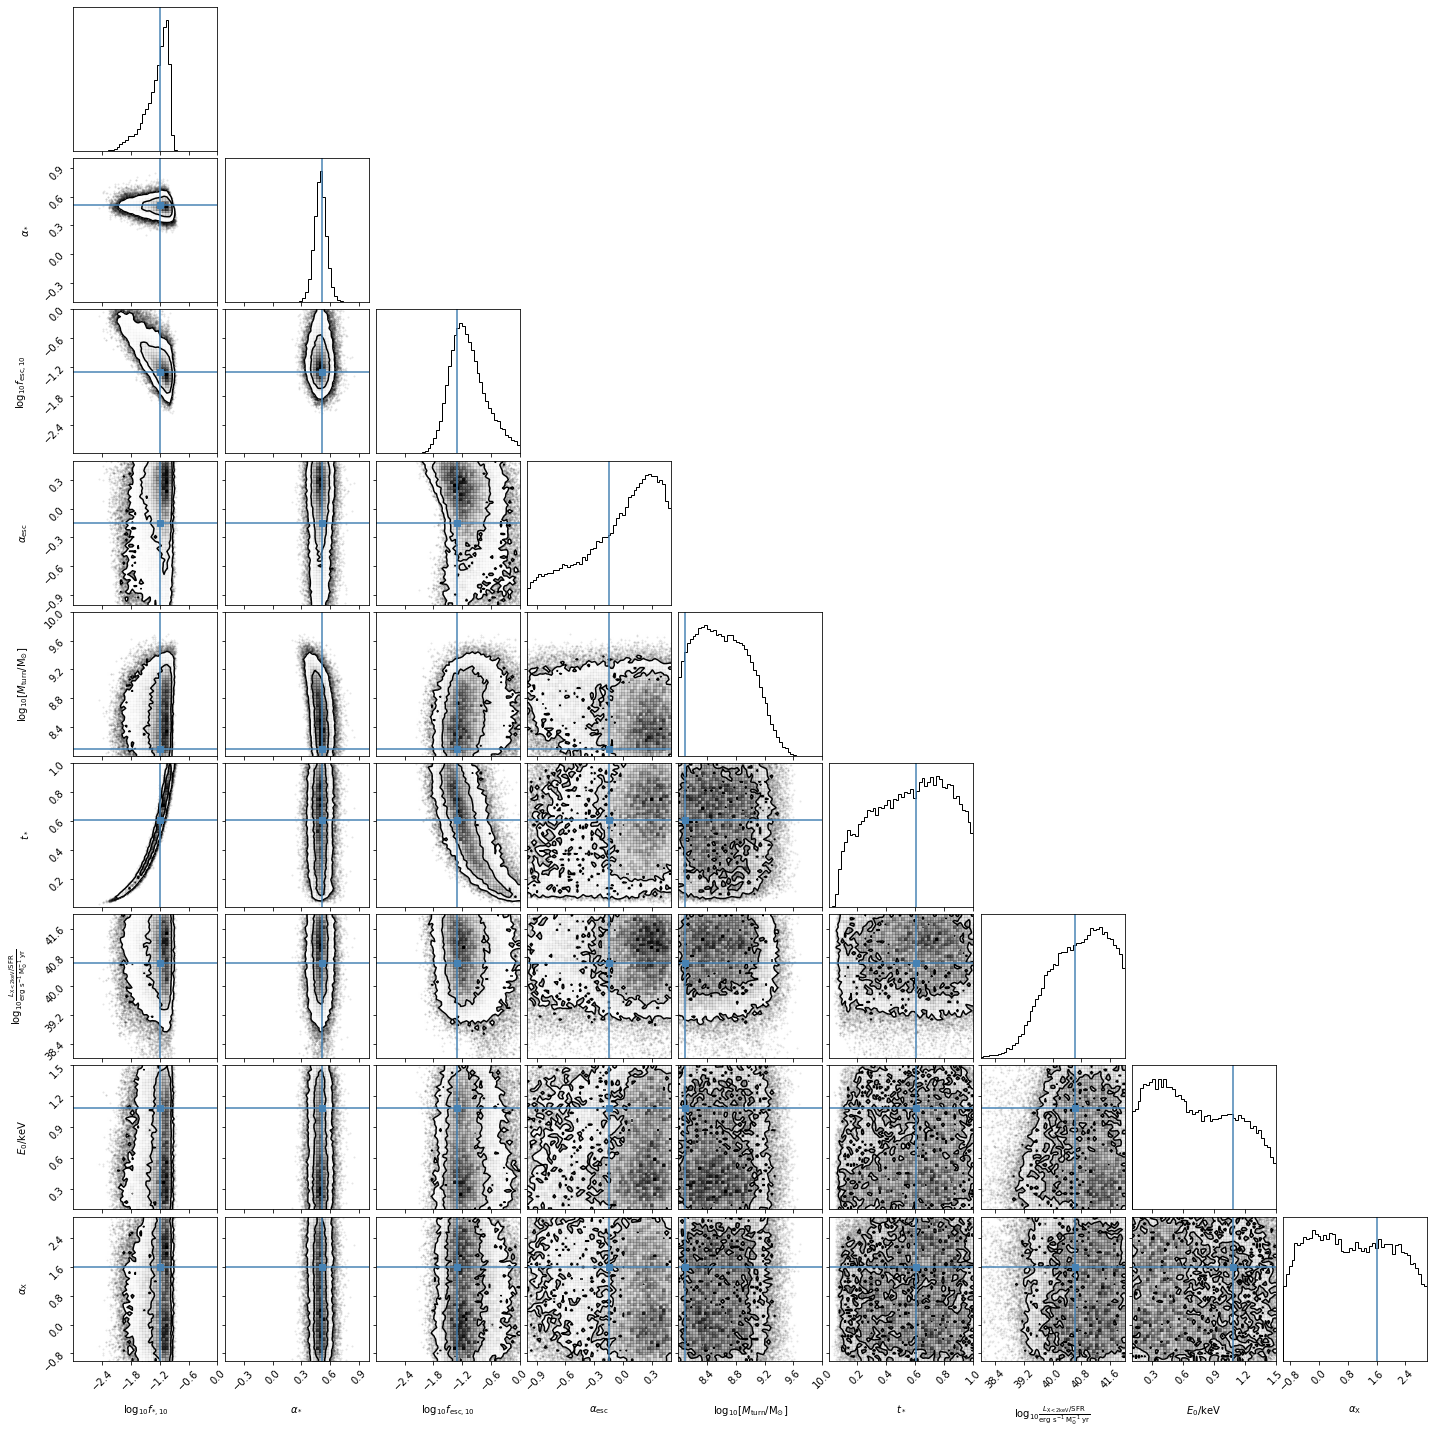

In [71]:
lnL = posterior[:,-1] # use this to find the max a posteriori (MAP) model
posterior = (posterior[:,:-1]* (limits[:,1] - limits[:,0]) + limits[:,0])
ML_index = np.argmin(np.sum(np.abs(features / posterior[np.argmax(lnL)] - 1),axis=1))

# We do need to find the index of the MAP model in features because AllFile.h5 is where other predictions are saved
# but let's make sure the MAP models in the posterior is identical to the one we find in features
print(features[ML_index],'\n', posterior[np.argmax(lnL)])
figure = corner.corner(posterior, bins=50,range=limits, alpha=0.5, labels=parameters, plot_contour=True, levels=[ 0.68, 0.95], truths=features[ML_index])

Explore: We will be training using the ~450k points shown before that more or less follows the posterior. However, does it matter to train the network using points from a pseudo-posterior or from a uniform distribution like what people normally do when they do not have a posterior?

## let's just visualize what the prediction looks like using the MAP model

points in AllFile3.h5 are in order, i.e. the nth row in `Walkers` corresponds to the nth row in other datasets

### global signals

(-110.0, 20.0)

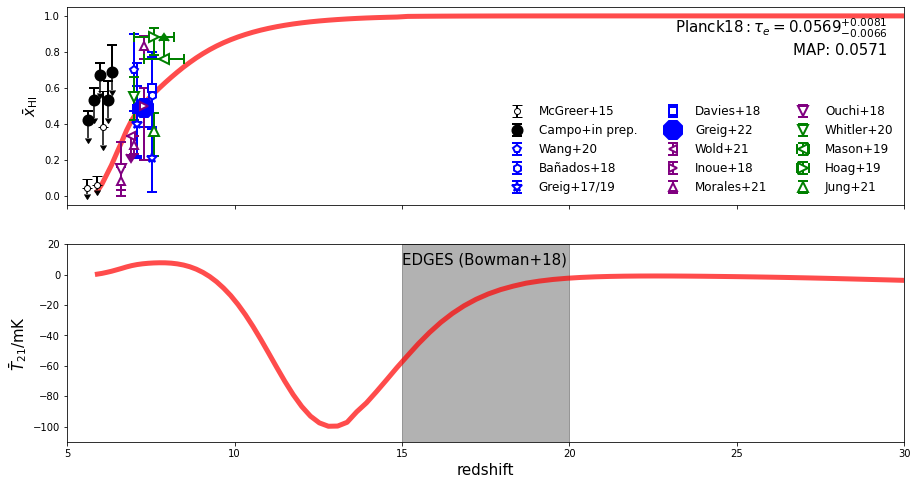

In [68]:
with h5py.File('AllFile3.h5','r') as f:
    zs = f['AveDatas'][ML_index,:,0] # redshift for global signals; this is the same for all models by construction
    xH = f['AveDatas'][ML_index,:,1] # neutral fraction
    Tb = f['AveDatas'][ML_index,:,2] # 21cm brightness temperature
    tau_e = f['TauDatas'][ML_index]  # CMB optical depth
    
fig, (axxH, axTb) = plt.subplots(2,1, figsize=(15,8), sharex=True)

# model
axxH.plot(zs, xH,color='r',alpha=0.7, lw=5)
axTb.plot(zs, Tb,color='r',alpha=0.7, lw=5)

# observations
# Dark Pixels
axxH.errorbar([5.6,6.07], [0.04,0.38], yerr=[[0,0],[0.05,0.20]], fmt='o',color='k', label='McGreer+15',mfc='white',capsize=5, elinewidth=2, markeredgewidth=1,alpha=1)
axxH.errorbar([5.6,6.07], [0.04,0.38], yerr=[[0.03,0.1],[0,0]], mfc='white',uplims=True, fmt=' ',color='k',alpha=1)
axxH.errorbar([5.9], [0.06], yerr=[[0],[0.05]],mfc='white', fmt='o',color='k',capsize=5, elinewidth=2, markeredgewidth=1,alpha=1)
axxH.errorbar([5.9], [0.06], yerr=[[0.03],[0]], uplims=True, fmt=' ',color='k',alpha=1)
axxH.errorbar([5.61,5.8,5.99,6.21,6.35], [0.42, 0.53,0.67,0.53,0.69], yerr=[[0,0,0,0,0],[0.05,0.07,0.07,0.11,0.15]], markersize=10,fmt='o',color='k', label='Campo+in prep.',capsize=5, elinewidth=2, markeredgewidth=2,alpha=1)
axxH.errorbar([5.61,5.8,5.99,6.21,6.35], [0.42, 0.53,0.67,0.53,0.69], yerr=[[0.1,0.1,0.1,0.1,0.1],[0,0,0,0,0]], markersize=20,uplims=True, fmt=' ',color='k',alpha=1)

# QSO damping
axxH.errorbar([7.0], [0.70], yerr=[[0.23],[0.20]], fmt='p',color='b', label='Wang+20',markersize=8,capsize=5, elinewidth=2,mfc='white', markeredgewidth=2,alpha=1)
axxH.errorbar([7.5413], [0.56], yerr=[[0.18],[0.21]], fmt='h',color='b', label='Bañados+18',markersize=8,capsize=5, elinewidth=2,mfc='white', markeredgewidth=2,alpha=1)
axxH.errorbar([7.0851,7.5413], [0.40,0.21], yerr=[[0.19,0.19],[0.21,0.17]], fmt='*',color='b', label='Greig+17/19',markersize=10,capsize=5, elinewidth=2, mfc='white',markeredgewidth=2,alpha=1)
axxH.errorbar([7.0851,7.5413], [0.48,0.60], yerr=[[0.26,0.23],[0.26,0.20]], fmt='s',color='b', label='Davies+18',markersize=8,capsize=5, elinewidth=2,mfc='white', markeredgewidth=2,alpha=1)
axxH.errorbar([7.29], [0.49], yerr=[0.11], xerr=[0.20], fmt='8',color='b', label='Greig+22',markersize=20,capsize=5, elinewidth=2, markeredgewidth=2,alpha=1)

# LAE fraction
## LF
axxH.errorbar([6.9], [0.33], yerr=[[0.1],[0.]], uplims=True, fmt='<',color='purple', label='Wold+21',markersize=8,capsize=5, elinewidth=2,  mfc='white',markeredgewidth=2,alpha=1)
axxH.errorbar([7.3], [0.5], yerr=[[0.3],[0.1]], fmt='>',color='purple', label='Inoue+18',markersize=8,capsize=5, elinewidth=2,  mfc='white',markeredgewidth=2,alpha=1)
#axxH.errorbar([5.7,6.6,7.0], [0.4,0.4,0.4], yerr=[[0.1,0.1,0.1],[0,0,0]], uplims=True, fmt='s',color='black',alpha=0.6)
axxH.errorbar([6.6,7.0,7.3], [0.08,0.28,0.83], yerr=[[0.05,0.05,0.07],[0.08,0.05,0.06]], fmt='^',color='purple', label='Morales+21',markersize=8,capsize=5, elinewidth=2,  mfc='white',markeredgewidth=2,alpha=1)
## clustering
axxH.errorbar([6.6], [0.15], yerr=[0.15], fmt='v',color='purple', label='Ouchi+18',markersize=10, capsize=5,mfc='white', elinewidth=2, markeredgewidth=2,alpha=1)

## EW
axxH.errorbar([7.0], [0.55], yerr=[[0.13],[0.11]], fmt='v',color='g', label='Whitler+20',markersize=10,capsize=5, elinewidth=2, mfc='white',markeredgewidth=2,alpha=1) #EW
axxH.errorbar([7.9], [0.76], xerr=[0.6], yerr=[[0.],[0.1]], lolims=True,fmt='<',label='Mason+19',color='g', markersize=10,capsize=5, elinewidth=2, mfc='white',markeredgewidth=2,alpha=1) #EW
axxH.errorbar([7.6], [0.88], yerr=[[0.1],[0.05]], xerr=[0.6],fmt='>',color='g', label='Hoag+19',markersize=10, capsize=5,mfc='white', elinewidth=2, markeredgewidth=2,alpha=1) #EW
axxH.errorbar([7.6], [0.36], yerr=[[0.14],[0.10]], fmt='^',color='g', label='Jung+21',markersize=10, capsize=5,mfc='white', elinewidth=2, markeredgewidth=2,alpha=1)

# CMB optical depth
axxH.text(0.98, 0.95, r'${\rm Planck18:} \tau_e = 0.0569^{+0.0081}_{-0.0066}$'+'\n'+
          'MAP: %.4f'%tau_e,ha='right',va='top',fontsize = 15,transform=axxH.transAxes) 


## EDGES
axTb.axvspan(15,20, alpha=0.3, color='k')
axTb.text(15, 15, 'EDGES (Bowman+18)',ha='left',va='top',fontsize = 15) 

axxH.legend(loc='lower right',fontsize=12,ncol=3,frameon=False)
axxH.set_ylabel(r"$\bar{x}_{\rm HI}$",fontsize=15)
axTb.set_ylabel(r"$\bar{T}_{21}/{\rm mK}$",fontsize=15)
axTb.set_xlabel('redshift', fontsize=15)
axTb.set_xlim(5,30)
axTb.set_ylim(-110,20)

### 21cm power spectra

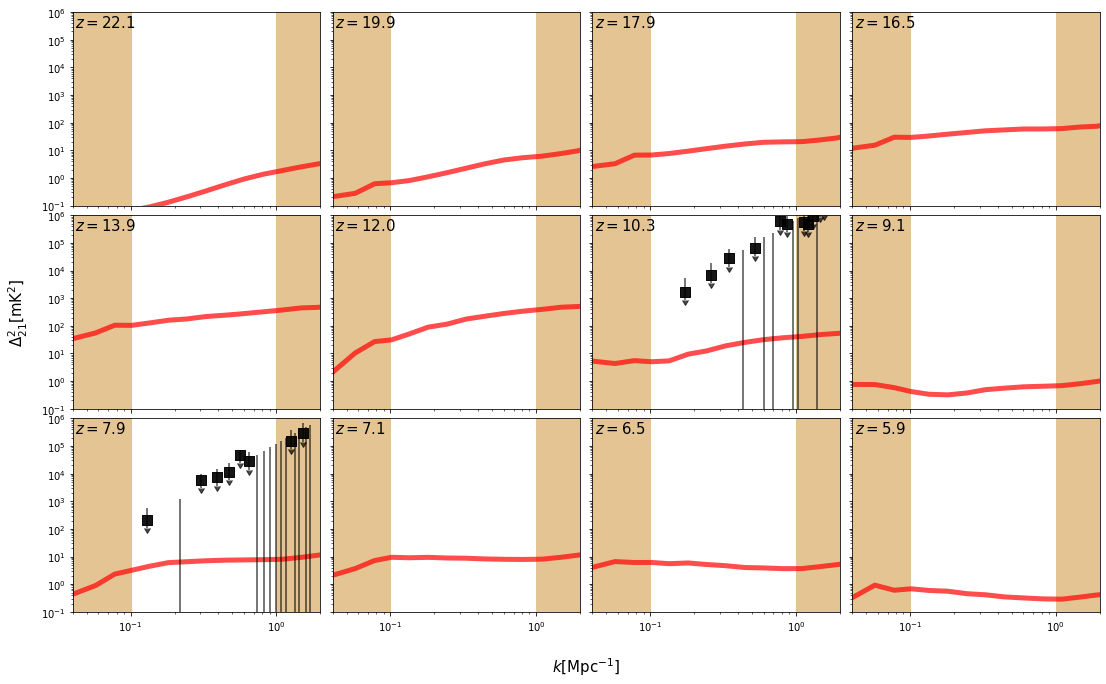

In [72]:
with h5py.File('AllFile3.h5','r') as f:
    ks = f['TotalPSDatas'][ML_index,:,0] # wavenumber for 21-cm power spectra, this is the same for all models by construction 
    ps = f['TotalPSDatas'][ML_index,:,1:]
    
# define the redshifts to plot
snapshots = [61,56,51,47,39,32,25,19,13,8, 4,0]

# define the axes limits
xlim = [4e-2,2]#[5e-2,2]
ylim = [1e-1,1e6]

fig, axsPS = plt.subplots(3,4, figsize= (15,9), sharex=True, sharey=True)
axsPS = axsPS.flatten()

# the MAP model
for ii in range(len(snapshots)):
    axsPS[ii].plot(ks, ps[:,snapshots[ii]],color='r',alpha=0.7, lw=5)

# observations
PS_limit_ks_z = np.fromfile('HERA_Phase1_Limits/PS_limit_ks_z8.bin') 
PS_limit_vals_z = np.fromfile('HERA_Phase1_Limits/PS_limit_vals_z8.bin')
PS_limit_vars_z = np.fromfile('HERA_Phase1_Limits/PS_limit_vars_z8.bin')
axsPS[8].errorbar(PS_limit_ks_z, PS_limit_vals_z, c='black', ls='', marker='s', ms=10, yerr=[np.zeros_like(PS_limit_vars_z), PS_limit_vars_z**0.5], alpha=0.7)
axsPS[8].errorbar(PS_limit_ks_z, PS_limit_vals_z, c='black', ls='', marker='s', ms=10, yerr=[PS_limit_vals_z*0.5, np.zeros_like(PS_limit_vars_z)], alpha=0.7, uplims=True)
PS_limit_ks_z = np.fromfile('HERA_Phase1_Limits/PS_limit_ks_z10.bin')
PS_limit_vals_z = np.fromfile('HERA_Phase1_Limits/PS_limit_vals_z10.bin')
PS_limit_vars_z = np.fromfile('HERA_Phase1_Limits/PS_limit_vars_z10.bin')
axsPS[6].errorbar(PS_limit_ks_z, PS_limit_vals_z, c='black', ls='', marker='s', ms=10, yerr=[np.zeros_like(PS_limit_vars_z), PS_limit_vars_z**0.5], alpha=0.7)
axsPS[6].errorbar(PS_limit_ks_z, PS_limit_vals_z, c='black', ls='', marker='s', ms=10, yerr=[PS_limit_vals_z*0.5, np.zeros_like(PS_limit_vars_z)], alpha=0.7, uplims=True)

# cosmetics
for ii in range((len(snapshots))):
    axsPS[ii].text(0.01, 0.99, r'$z=%.1f$'%zs[::-1][snapshots[ii]],horizontalalignment='left',verticalalignment='top',
                    transform=axsPS[ii].transAxes,fontsize = 15) 
    axsPS[ii].axvspan(xlim[0], 0.1, color='#e5c494',hatch='x', alpha=1)
    axsPS[ii].axvspan(1, xlim[1], color='#e5c494',hatch='x', alpha=1)

    axsPS[ii].grid(False)
    axsPS[ii].set_xscale('log')
    axsPS[ii].set_yscale('log')
    axsPS[ii].set_xlim(xlim)
    axsPS[ii].set_ylim(ylim)

plt.tight_layout()
fig.subplots_adjust(hspace=0.05,wspace=0.05)

fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axes
plt.tick_params(labelcolor='none', top='off', bottom='off', left='off', right='off')
plt.xticks([])
plt.yticks([])
plt.grid(False)

plt.xlabel('\n\n'+r'$k[{\rm Mpc}^{-1}]$', fontsize=15)
plt.ylabel(r'$\Delta_{21}^2[{\rm mK}^{2}]$'+'\n\n', fontsize=15);

### galaxy luminosity functions

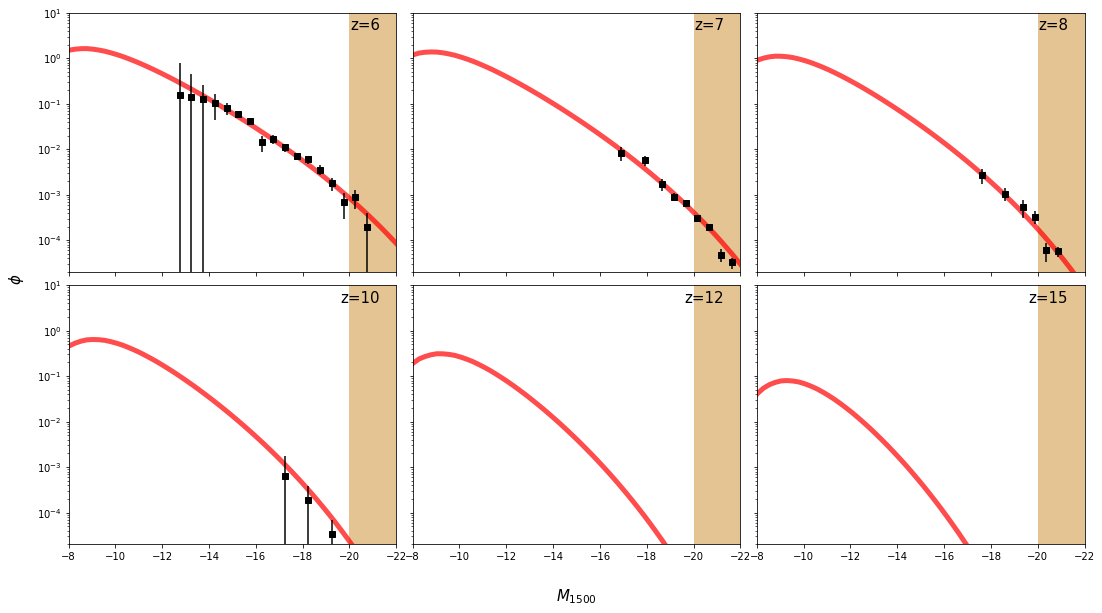

In [74]:
# predefined LF redshifts and UV magnitudes
LF_redshifts = [6,7,8,10,12,15]
Muvs = np.linspace(-30,-5,100)
fig, axsLF = plt.subplots(2,3, figsize=(15,8), sharex=True, sharey=True)
axsLF = axsLF.flatten()

with h5py.File('AllFile3.h5','r') as f:
    for qq, redshift in enumerate(LF_redshifts):
        Nmuvs = f['LFDatas_%d'%redshift].shape[1]
        if qq == 0 :
            phis = np.empty([len(LF_redshifts), Nmuvs])+np.nan

        results = f['LFDatas_%d'%redshift][ML_index]
        
        # varing models output the number density at different UV magnitudes.
        # to eliminate having UV magnitudes also as an output, 
        # we use interpolation to force all models to output number density at the same magnitudes, i.e., `Muvs`.
        phis[qq] = 10**interp1d(results[:,0], results[:,1], fill_value="extrapolate")(Muvs)
        
        axsLF[qq].plot(Muvs, phis[qq], color='r',alpha=0.7, lw=5)
    
        fLF = 'LFs/LF_obs_Bouwens_%.6f.txt'%redshift
        if os.path.exists(fLF):
            datainput = np.loadtxt(fLF)
            axsLF[qq].errorbar(datainput[:,0], (datainput[:,1]),yerr=datainput[:,2], fmt='s',color='black',zorder=2)
        axsLF[qq].text(0.95,0.98, "z=%d"%redshift,horizontalalignment='right',\
                      verticalalignment='top',transform=axsLF[qq].transAxes,fontsize=15)

        axsLF[qq].set_xlim(-8,-22)
        axsLF[qq].set_ylim(2e-5,10)
        axsLF[qq].set_yscale('log')
        axsLF[qq].axvspan(-20, -22, color='#e5c494',hatch='x', alpha=1)
        
        
plt.tight_layout()
fig.subplots_adjust(hspace=0.05,wspace=0.05)

fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axes
plt.tick_params(labelcolor='none', top='off', bottom='off', left='off', right='off')
plt.xticks([])
plt.yticks([])
plt.grid(False)

plt.xlabel('\n\n'+r'$M_{\rm 1500}$', fontsize=15)
plt.ylabel(r'$\phi$'+'\n\n', fontsize=15);

# Having the database inspected and understood, we now begin to train the network

## a few more data preparation

we have defined the features of our network. Let's normalize from having a range of `limits` to [0,1] to elimate having different dynamic ranges.

In [10]:
features = ( features - limits[:,0] ) / (limits[:,1] - limits[:,0])

pick the outputs that we would like to emulate with the network. 

For the purpose of using emulator for quick Bayesian inference, we emulate points that will go into the likelihoods. 

These are xHI at z=5.9 (vs McGreer+15, 1D); 

CMB optical depth (vs Planck+18, 1D); 

21-cm PS at z=8 (19D) and z=10 (18D); and 

UV LFs at z=6 (15D); let's ignore z=7(5D), 8(4D) and 10(3D) for speed.

In total, the outputs are 54D.

In [76]:
if os.path.exists('database.npy'):
    outputs = np.load('database.npy')
else:
    outputs = np.zeros([len(features), 54])

    current_index = 0
    with h5py.File('AllFile3.h5','r') as f:

        # neutral fraction
        outputs[:,current_index] = f['AveDatas'][:,-1,1] # by design, the last entry is for z=5.9
        current_index+=1

        # CMB optical depth
        outputs[:,current_index] = f['TauDatas'][:]  
        current_index+=1

        #z=8 21cm PS, still need to interpolate to get the power at the observed wavenumbers
        PS_limit_ks_z = np.fromfile('HERA_Phase1_Limits/PS_limit_ks_z8.bin') 
        ps = np.log10(f['TotalPSDatas'][:,:,1+snapshots[8]]) # zs[::-1][snapshots[8]] = 8
        # network normally cannot deal with NaN/inf, the simplest way is to replace them with zeros. 
        # You can also mask those points out or resample those invalid points from some distribution.
        ps = np.nan_to_num(ps) 
        outputs[:, current_index:current_index+len(PS_limit_ks_z)] = interp1d(ks, ps, fill_value="extrapolate")(PS_limit_ks_z)
        current_index+=len(PS_limit_ks_z)

        #z=10 21cm PS, still need to interpolate to get the power at the observed wavenumbers
        PS_limit_ks_z = np.fromfile('HERA_Phase1_Limits/PS_limit_ks_z10.bin') 
        ps = np.log10(f['TotalPSDatas'][:,:,1+snapshots[6]]) # zs[::-1][snapshots[6]] = 10
        ps = np.nan_to_num(ps) 
        outputs[:, current_index:current_index+len(PS_limit_ks_z)] = interp1d(ks, ps, fill_value="extrapolate")(PS_limit_ks_z)
        current_index+=len(PS_limit_ks_z)

        # UV LF, still need to interpolate to get the number density at the observed UV magnitudes
        redshift=6
        fLF = 'LFs/LF_obs_Bouwens_%.6f.txt'%redshift
        observed_muv = np.loadtxt(fLF, usecols=0)
        observed_muv = observed_muv[observed_muv>-20]

        results = f['LFDatas_%d'%redshift]
        for ii in range(len(features)):
            outputs[ii, current_index:current_index+len(observed_muv)] = interp1d(results[ii,:,0], results[ii,:,1], fill_value="extrapolate")(observed_muv)

        current_index+=len(observed_muv)

## a side note

P.S. We have recently found that adding more data points helps the network better learn the overall shape of a function, e.g. ps or UV LF. This is particularly true for functions with higher non-linearity which might be hard to capture with only a few points.

For instance, if my model predicts sine waves but my training set only has 3 points. The network might learn a linear correlation between those points and miss the true correlation.

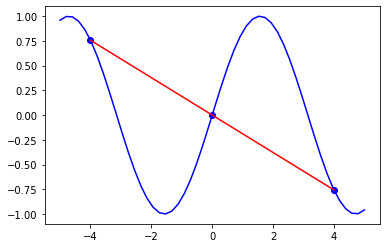

In [127]:
x = np.linspace(-5,5)
x2 = [-4,0,4]

y = np.sin(x)
y2 = np.sin(x2)

plt.plot(x,y,c='b')
plt.scatter(x2,y2,c='b')
plt.plot(x2,y2,c='r')

This can be fine if, for instance, my model only predicts different normalization with different (astrophysical) parameters, then learning the wrong correlation will still give the correct prediction.

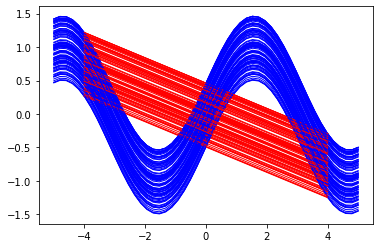

In [128]:
x = np.linspace(-5,5)
x2 = [-4,0,4]
np.random.seed(1993)
for i in np.random.random(100)-0.5:
    y = np.sin(x) + i
    plt.plot(x,y, lw=1, c='b')
    y2 = np.sin(x2) + i
    plt.plot(x2,y2, lw=1, c='r')

However, if the model also predicts a different phase when varying parameters, fewer sampling points can make the learning very challenging.

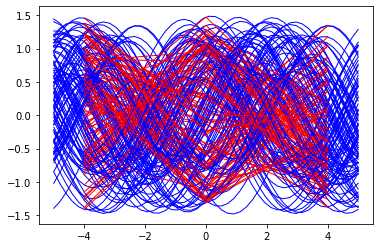

In [129]:
x = np.linspace(-5,5)
x2 = [-4,0,4]
np.random.seed(1993)
for i,j in zip((np.random.random(100)-0.5)*5, np.random.random(100)-0.5):
    y = np.sin(x+i)+j
    plt.plot(x,y, lw=1, c='b')
    y2 = np.sin(x2+i) + j
    plt.plot(x2,y2, lw=1, c='r')

## Split into training set, validation set, test set


In [130]:
# 60% of the data goes into the actual regression, 
# i.e. this is the data that the network will try to model
f_train = 0.6                           

# 25% will be used to valid the performance at each training step, 
# i.e. this is the data that will guide the network to improve 
# even if it has already found a way to model the training data
f_valid = 0.25                           

# the rest is used to provide an unbiased evaluation once the model is locked
# validation set becomes more biased as it supervises the network
# hence a dataset that the network has never seen is needed.
f_test = 1 - f_valid - f_train

random_indices = np.arange(len(features))
np.random.shuffle(random_indices)

N_train = int(np.round(len(features) * f_train))
N_valid = int(np.round(len(features) * f_valid))
N_test = len(features) - N_train - N_valid

print('Training set size: ', N_train)
print('Validation set size: ', N_valid)
print('Test set size: ', N_test)

X_train = features[:N_train]
X_valid = features[N_train:N_train+N_valid]
X_test = features[-N_test:]

Y_train = outputs[:N_train]
Y_valid = outputs[N_train:N_train+N_valid]
Y_test = outputs[-N_test:]

# This is the size of a single training batch (training is not done on the entire test set at once, but on batches of data)
# You can play with this number but it shouldn't make a very big difference as long as it is ~ 100 
# If it is too big / small, the network will not learn as well
batch_size = 64 

# convert the database into tensorflow format
x_train = tf.data.Dataset.from_tensor_slices(X_train)
x_val = tf.data.Dataset.from_tensor_slices(X_valid)
y_train = tf.data.Dataset.from_tensor_slices(Y_train)
y_val = tf.data.Dataset.from_tensor_slices(Y_valid)
training_data = tf.data.Dataset.zip((x_train, y_train)).shuffle(X_train.shape[0]).batch(batch_size)
validation_data = tf.data.Dataset.zip((x_val, y_val)).shuffle(X_valid.shape[0]).batch(batch_size)

Training set size:  270643
Validation set size:  112768
Test set size:  67660


2022-08-11 14:28:29.352860: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-08-11 14:28:29.378030: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (gadi-cpu-clx-0382.gadi.nci.org.au): /proc/driver/nvidia/version does not exist
2022-08-11 14:28:29.520451: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## some callback functions to improve the training

In [134]:
callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(patience = 20), # If loss does not improve for 20 epochs, reduce learning rate
    tf.keras.callbacks.EarlyStopping(patience = 50) # If loss does not improve for 50 epochs, stop the learning
]

## build the network architecture

In [14]:
# Input size = number of params
input_layer = layers.Input(shape = X_train.shape[-1])

# Hidden fully-connected layers
# Number of nodes and hidden layers is arbitrary
output = layers.Dense(64)(input_layer)
# Batch normalization = normalize the training weights at every batch.
# You can try removing it and you will find that the results are a bit worse
# This is because normalization helps stabilising the network. It can also help it run faster.
# In general, batch normalization always helps improve accuracy a little bit.
output = layers.BatchNormalization()(output)
output = layers.ReLU()(output)
output = layers.Dense(128)(output)
output = layers.BatchNormalization()(output)
output = layers.ReLU()(output)
output = layers.Dense(64)(output)
output = layers.BatchNormalization()(output)
output = layers.ReLU()(output)
# Last layer output shape = number of redshift bins in globale signal = 84
output = layers.Dense(Y_train.shape[-1])(output)
model = tf.keras.Model(inputs = [input_layer], outputs = [output])
model.summary()

# define optimizer
opt = Adam(learning_rate = 1e-3)
# Use mean squared error for the loss function
model.compile(loss = 'mse', optimizer = opt)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 9)]               0         
_________________________________________________________________
dense (Dense)                (None, 64)                640       
_________________________________________________________________
batch_normalization (BatchNo (None, 64)                256       
_________________________________________________________________
re_lu (ReLU)                 (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               8320      
_________________________________________________________________
batch_normalization_1 (Batch (None, 128)               512       
_________________________________________________________________
re_lu_1 (ReLU)               (None, 128)               0     

## starting training

In [15]:
history = model.fit(training_data,
                  epochs = 300,
                  batch_size = batch_size,
                  validation_data = validation_data,
                  callbacks = callbacks,
                  shuffle = True # shuffle the data in each batch
                  )

Epoch 1/300


2022-04-21 05:28:13.217501: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-04-21 05:28:13.242848: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 3192650000 Hz


4229/4229 [==============================] - 30s 7ms/step - loss: 0.5365 - val_loss: 0.0540
Epoch 2/300
4229/4229 [==============================] - 27s 6ms/step - loss: 0.1961 - val_loss: 0.0293
Epoch 3/300
4229/4229 [==============================] - 27s 6ms/step - loss: 0.1766 - val_loss: 0.0264
Epoch 4/300
4229/4229 [==============================] - 28s 7ms/step - loss: 0.1660 - val_loss: 0.0247
Epoch 5/300
4229/4229 [==============================] - 23s 5ms/step - loss: 0.1572 - val_loss: 0.0278
Epoch 6/300
4229/4229 [==============================] - 23s 5ms/step - loss: 0.1481 - val_loss: 0.0225
Epoch 7/300
4229/4229 [==============================] - 23s 5ms/step - loss: 0.1473 - val_loss: 0.0239
Epoch 8/300
4229/4229 [==============================] - 24s 5ms/step - loss: 0.1401 - val_loss: 0.0225
Epoch 9/300
4229/4229 [==============================] - 24s 6ms/step - loss: 0.1393 - val_loss: 0.0193
Epoch 10/300
4229/4229 [==============================] - 24s 6ms/step - los

## check how the traning goes

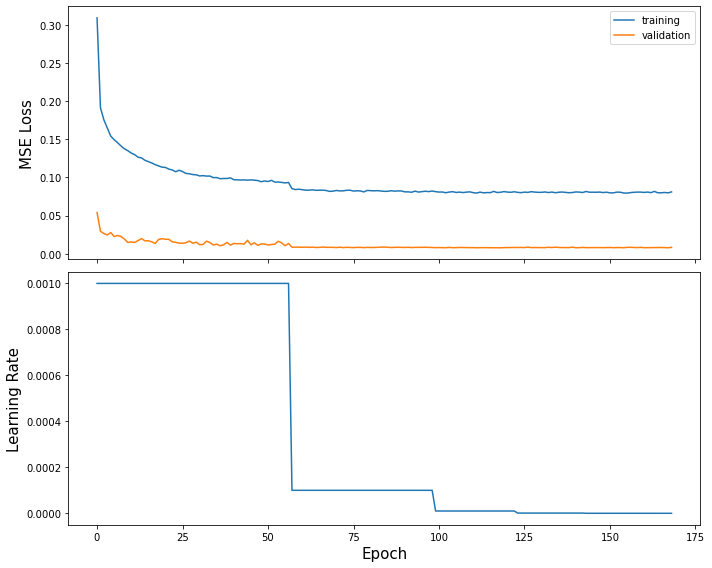

In [16]:
fig, axs = plt.subplots(2,1, figsize=(10,8), sharex=True)

axs[0].plot(history.history['loss'], label = 'training')
axs[0].plot(history.history['val_loss'], label = 'validation')
axs[0].set_ylabel('MSE Loss', fontsize=15)
axs[0].legend(loc='upper right')
axs[1].plot(history.history['lr'])
axs[1].set_ylabel('Learning Rate', fontsize=15)
axs[1].set_xlabel('Epoch', fontsize=15)

plt.tight_layout()
fig.subplots_adjust(hspace=0.05,wspace=0.05)

## Test emulator with test set = data that the network never saw


In [17]:
prediction = model.predict(X_test)

#### let's first take a fewer random test set and see the 21cm PS and galaxy UV LFs

Text(0, 0.5, '$\\phi$\n\n')

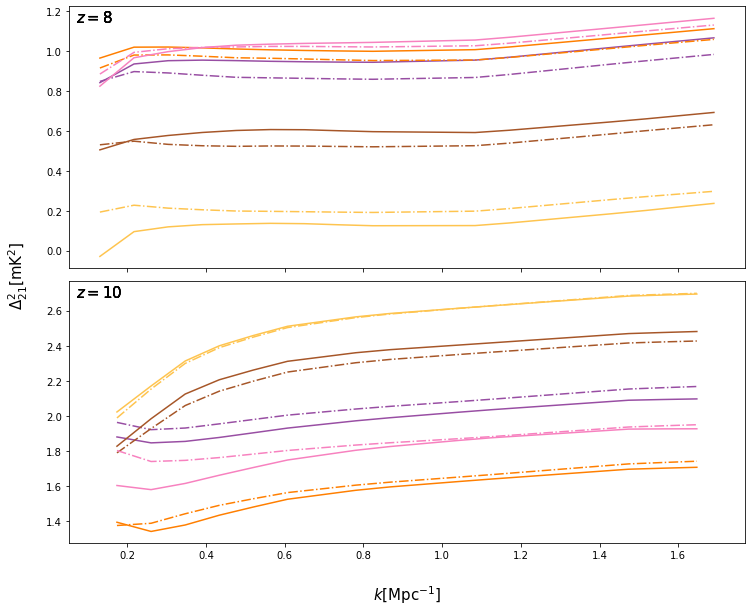

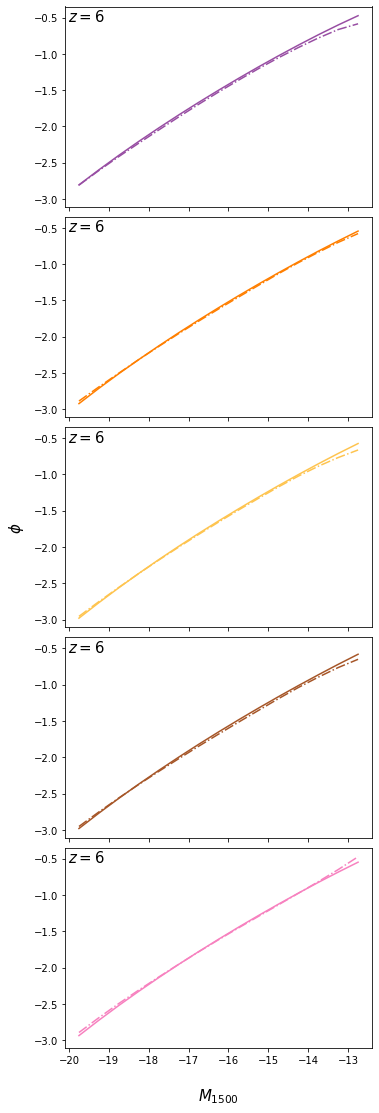

In [18]:
Ntest_show = 5
current_index = 2 # skip the first two 1D datasets
colors         = ['#984ea3','#ff7f00','#fec44f','#a65628','#f781bf']

fig, axs = plt.subplots(2,1, figsize=(10,8), sharex=True)
for ii in range(Ntest_show):
     
    #z=8 21cm PS
    PS_limit_ks_z = np.fromfile('HERA_Phase1_Limits/PS_limit_ks_z8.bin')
    axs[0].plot(PS_limit_ks_z, Y_test[ii, current_index:current_index+len(PS_limit_ks_z)], color=colors[ii])
    axs[0].plot(PS_limit_ks_z, prediction[ii, current_index:current_index+len(PS_limit_ks_z)], color=colors[ii], ls='-.')
    current_index+=len(PS_limit_ks_z)
        
    #z=10 21cm PS
    PS_limit_ks_z = np.fromfile('HERA_Phase1_Limits/PS_limit_ks_z10.bin') 
    axs[1].plot(PS_limit_ks_z, Y_test[ii, current_index:current_index+len(PS_limit_ks_z)], color=colors[ii])
    axs[1].plot(PS_limit_ks_z, prediction[ii, current_index:current_index+len(PS_limit_ks_z)], color=colors[ii], ls='-.')
    if ii < Ntest_show-1: 
        current_index=2
    else:
        current_index+=len(PS_limit_ks_z)
 
    axs[0].text(0.01, 0.99, r'$z=8$',ha='left',va='top',transform=axs[0].transAxes,fontsize = 15) 
    axs[1].text(0.01, 0.99, r'$z=10$',ha='left',va='top',transform=axs[1].transAxes,fontsize = 15) 
   
plt.tight_layout()
fig.subplots_adjust(hspace=0.05,wspace=0.05)

fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axes
plt.tick_params(labelcolor='none', top='off', bottom='off', left='off', right='off')
plt.xticks([])
plt.yticks([])
plt.grid(False)

plt.xlabel('\n\n'+r'$k[{\rm Mpc}^{-1}]$', fontsize=15)
plt.ylabel(r'$\Delta_{21}^2[{\rm mK}^{2}]$'+'\n\n', fontsize=15)



fig, axs = plt.subplots(5,1, figsize=(5,15),sharex=True, sharey=True)
# UV LF @ z=6
redshift=6
fLF = 'LFs/LF_obs_Bouwens_%.6f.txt'%redshift
for ii in range(Ntest_show):
    observed_muv = np.loadtxt(fLF, usecols=0)
    observed_muv = observed_muv[observed_muv>-20]
    axs[ii].plot(observed_muv, Y_test[ii, current_index:current_index+len(observed_muv)], color=colors[ii])
    axs[ii].plot(observed_muv, prediction[ii, current_index:current_index+len(observed_muv)], color=colors[ii], ls='-.')           
    axs[ii].text(0.01, 0.99, r'$z=6$',ha='left',va='top',transform=axs[ii].transAxes,fontsize = 15) 

plt.tight_layout()
fig.subplots_adjust(hspace=0.05,wspace=0.05)

fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axes
plt.tick_params(labelcolor='none', top='off', bottom='off', left='off', right='off')
plt.xticks([])
plt.yticks([])
plt.grid(False)

plt.xlabel('\n\n'+r'$M_{\rm 1500}$', fontsize=15)
plt.ylabel(r'$\phi$'+'\n\n', fontsize=15)

### let's check all 54D outputs

/tmp/ipykernel_1072131/102285634.py:4: RuntimeWarning: divide by zero encountered in true_divide
  frac_err = (prediction - Y_test) / Y_test


Text(0, 0.5, 'Histogram')

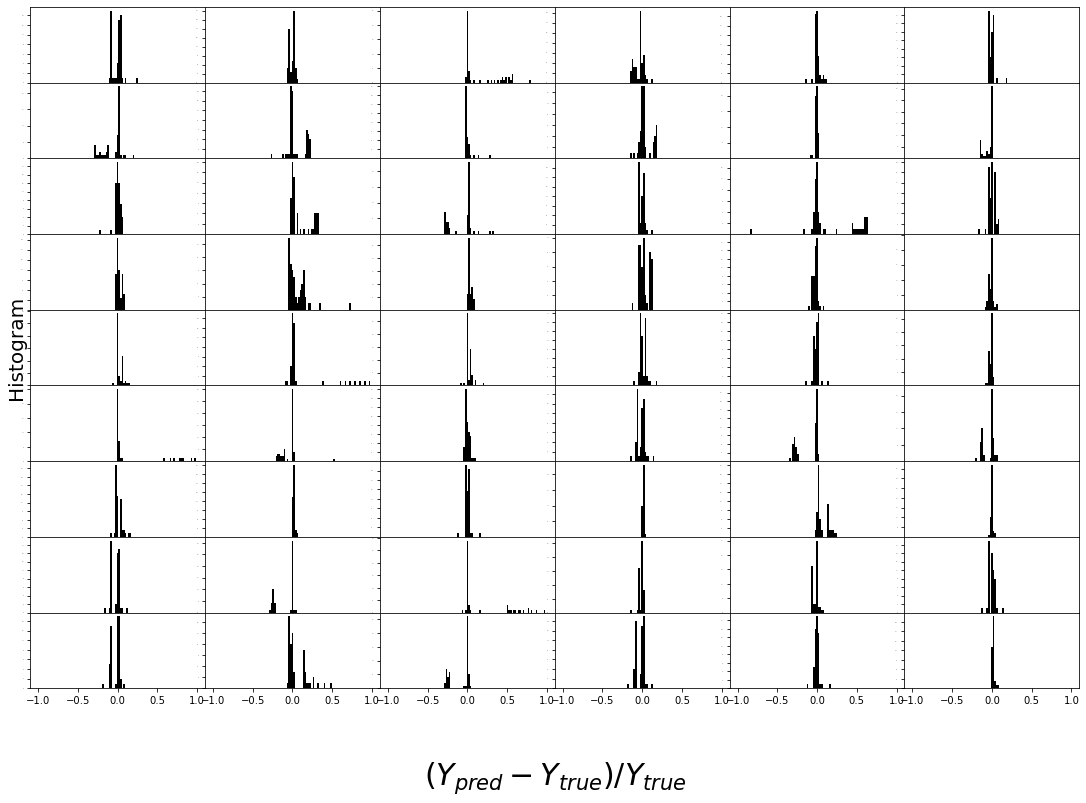

In [19]:
fig, axs = plt.subplots(9,6, figsize=(15,10), sharex=True)
axs = axs.flatten()

frac_err = (prediction - Y_test) / Y_test
for ii in range(Y_test.shape[1]):
    axs[ii].hist(frac_err[ii], bins=np.linspace(-1,1,100), color='k')
    axs[ii].yaxis.set_tick_params(labelsize=0)

plt.tight_layout()
fig.subplots_adjust(hspace=0.0,wspace=0.0)

fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axes
plt.tick_params(labelcolor='none', top='off', bottom='off', left='off', right='off')
plt.xticks([])
plt.yticks([])
plt.grid(False)

plt.xlabel('\n\n'+r'$({Y_{pred} - Y_{true}})/{Y_{true}}$', fontsize = 30)
plt.ylabel('Histogram', fontsize = 20)

# save the model for inference

In [20]:
model.save('emulator')

2022-04-21 06:29:25.105382: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: emulator/assets
